# FORECASTING SALES OF RETAIL OUTLET

### INDEX:

1. Dataset Description
2. Data Preparation
3. Data Cleaning
4. EXPLORATORY DATA ANALYSIS-EDA
5. Stationarity
6. Univariate Modelling
7. Creating an ARIMA Model
8. Creating an SARIMA Model
9. Future Scope

#### 1 Dataset Description:

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in 
every shop for the test set. Note that the list of shops and products slightly changes every month. 
Creating a robust model that can handle such situations is part of the challenge.

##### File descriptions:

1. sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
2. test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
3. sample_submission.csv - a sample submission file in the correct format.
4. items.csv - supplemental information about the items/products.
5. item_categories.csv - supplemental information about the items categories.
6. shops.csv- supplemental information about the shops.

##### Data fields:

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

This dataset is permitted to be used for any purpose, including commercial use.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sales = pd.read_csv('E:\MSC DATA SCIENCE\TCS Internship\CSV Files/sales_train.csv')
item_cat = pd.read_csv('E:\MSC DATA SCIENCE\TCS Internship\CSV Files/item_categories.csv')
items = pd.read_csv('E:\MSC DATA SCIENCE\TCS Internship\CSV Files/items.csv')
sample = pd.read_csv('E:\MSC DATA SCIENCE\TCS Internship\CSV Files/sample_submission.csv')
shop = pd.read_csv('E:\MSC DATA SCIENCE\TCS Internship\CSV Files/shops.csv')
test = pd.read_csv('E:\MSC DATA SCIENCE\TCS Internship\CSV Files/test.csv')

In [7]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [10]:
shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [15]:
print('sales shape:',sales.shape)
print('item_cat shape:',item_cat.shape)
print('items shape:',items.shape)
print('sample shape:',sample.shape)
print('shop shape:',shop.shape)
print('test shape:',test.shape)

sales shape: (2935849, 6)
item_cat shape: (84, 2)
items shape: (22170, 3)
sample shape: (214200, 2)
shop shape: (60, 2)
test shape: (214200, 3)


#### 2 Data Preparation

For a summarized view of the dataset, we need to merge all these three different dataframes into one single dataframe. This will help in easy and smooth analysis and EDA.

In [16]:
ssales = (sales.merge(items ,on="item_id", how='left'))

In [17]:
ssales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56


In [18]:
print('ssales shape',ssales.shape)

ssales shape (2935849, 8)


In [19]:
ssales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id'],
      dtype='object')

In [20]:
ssales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   shop_id           int64  
 3   item_id           int64  
 4   item_price        float64
 5   item_cnt_day      float64
 6   item_name         object 
 7   item_category_id  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 201.6+ MB


convert date object to datetime

In [21]:
# Convert to another format (e.g., 'DD-MM-YYYY')
ssales['date'] = pd.to_datetime(ssales['date'], format='%d.%m.%Y')

In [22]:
ssales['date'] = pd.to_datetime(ssales['date'])

In [23]:
ssales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int64         
 2   shop_id           int64         
 3   item_id           int64         
 4   item_price        float64       
 5   item_cnt_day      float64       
 6   item_name         object        
 7   item_category_id  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 201.6+ MB


In [24]:
ssales.iloc[:,0].unique()

array(['2013-01-02T00:00:00.000000000', '2013-01-03T00:00:00.000000000',
       '2013-01-05T00:00:00.000000000', ...,
       '2015-10-28T00:00:00.000000000', '2015-10-25T00:00:00.000000000',
       '2015-10-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [25]:
def uniquevals(col):
    print(f'Unique Values in {col} is : {ssales[col].unique()}')
    
def valuecounts(col):
    print(f'Valuecounts of {col} is: {len(ssales[col].value_counts())}')
    
    
    
    
for col in ssales.columns:
    valuecounts(col)
    uniquevals(col)
    print("-"*75)

Valuecounts of date is: 1034
Unique Values in date is : ['2013-01-02T00:00:00.000000000' '2013-01-03T00:00:00.000000000'
 '2013-01-05T00:00:00.000000000' ... '2015-10-28T00:00:00.000000000'
 '2015-10-25T00:00:00.000000000' '2015-10-13T00:00:00.000000000']
---------------------------------------------------------------------------
Valuecounts of date_block_num is: 34
Unique Values in date_block_num is : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
---------------------------------------------------------------------------
Valuecounts of shop_id is: 60
Unique Values in shop_id is : [59 25 24 23 19 22 18 21 28 27 29 26  4  6  2  3  7  0  1 16 15  8 10 14
 13 12 53 31 30 32 35 56 54 47 50 42 43 52 51 41 38 44 37 46 45  5 57 58
 55 17  9 49 39 40 48 34 33 20 11 36]
---------------------------------------------------------------------------
Valuecounts of item_id is: 21807
Unique Values in item_id is : [22154  2552  2554 ...  7610  

#### 3 Data Cleaning

In [27]:
!pip install missingno


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import missingno as msno
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
warnings.filterwarnings('ignore', message='SettingWithCopyWarning')

There are some unnecessary columns which we do not need for further data analysis. Dropping those columns.

In [29]:
import missingno as msno
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

<Axes: >

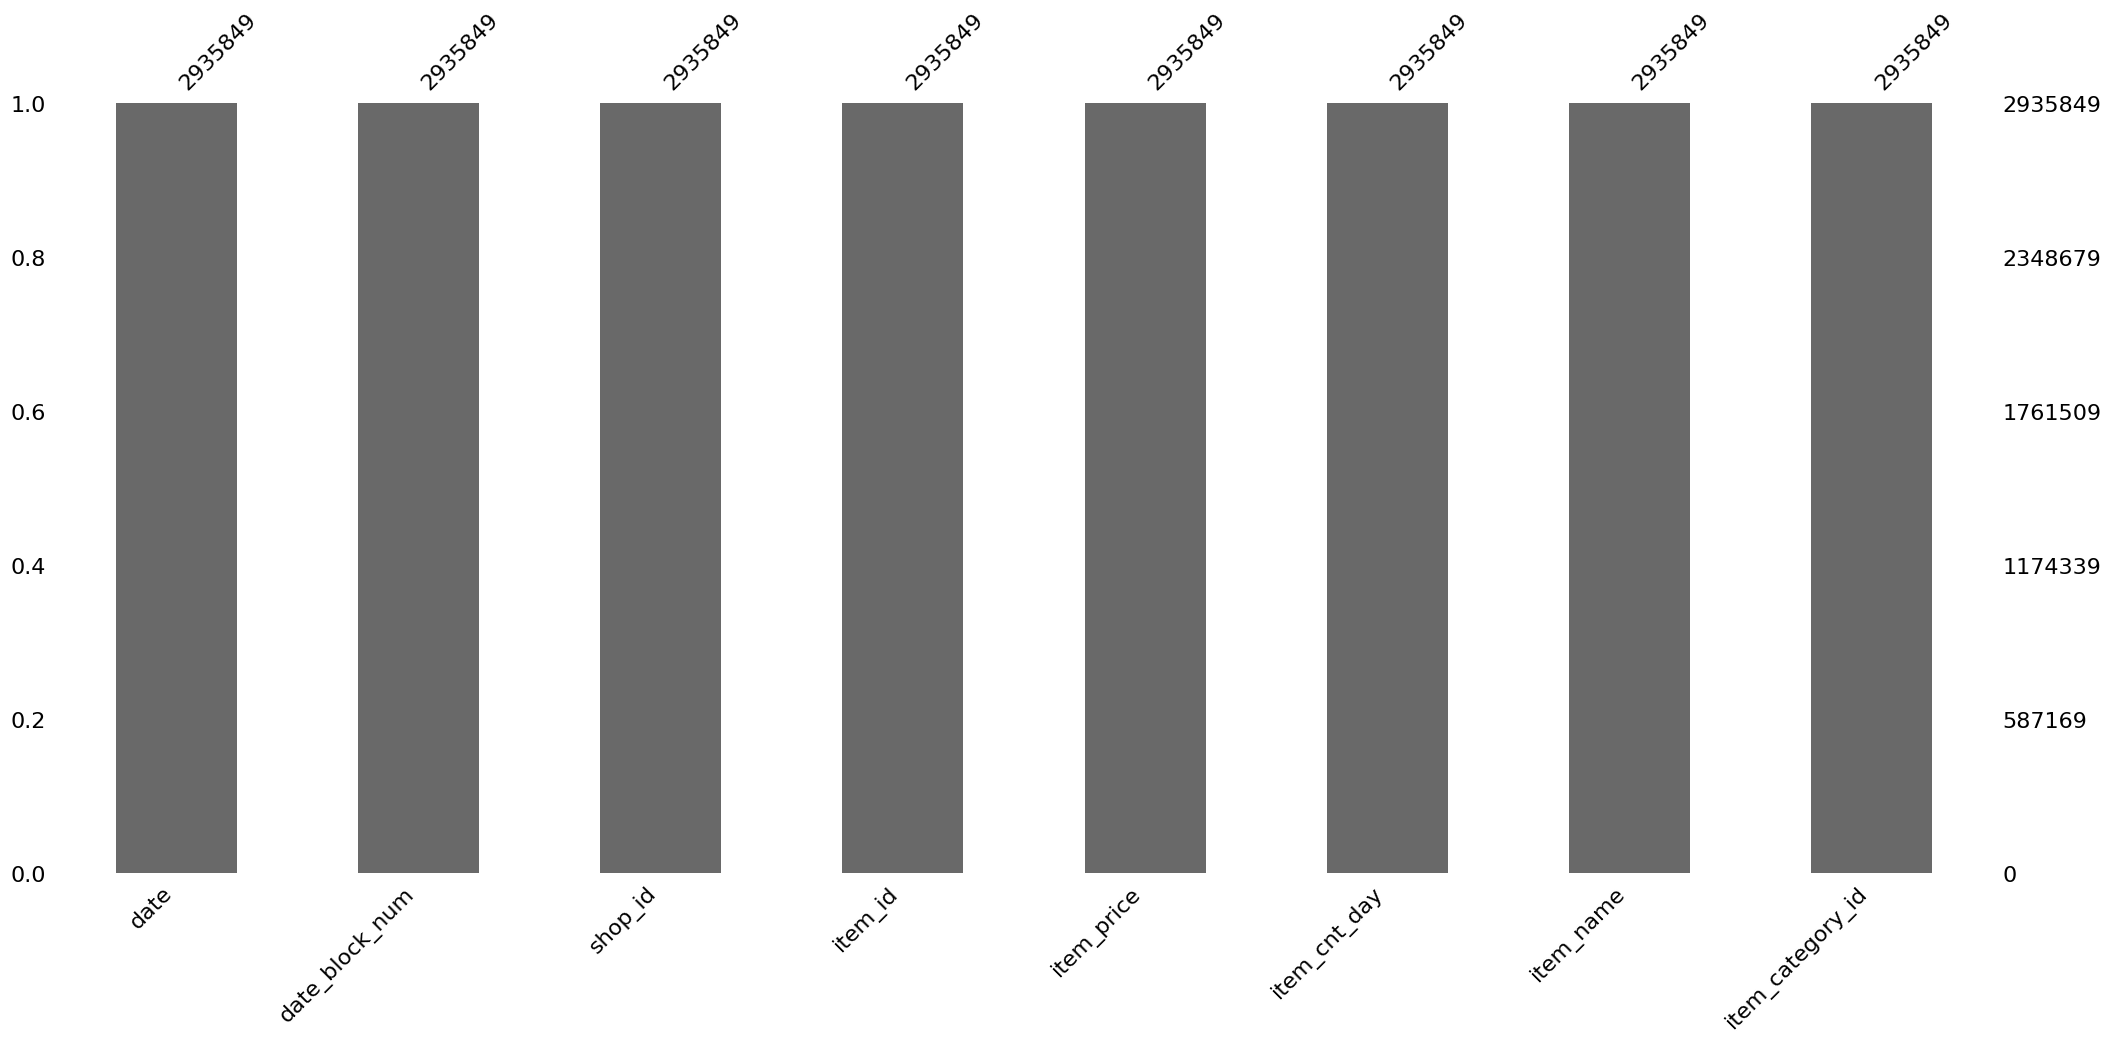

In [30]:
msno.bar(ssales)

In [31]:
'''
so on observation we can see that the null value is not present in Loan Approval Data Set dataset,
as shown ↓
'''
print()
ssales.isna().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_name           0
item_category_id    0
dtype: int64

In [32]:
ssales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [33]:
ssales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int64         
 2   shop_id           int64         
 3   item_id           int64         
 4   item_price        float64       
 5   item_cnt_day      float64       
 6   item_name         object        
 7   item_category_id  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 201.6+ MB


As we can see in the output.

1. There are 2935848 entries
- There are total 8 features (0 to 7)
-There are four types of datatype dtypes: datetime64(1), float64(2), int64(4), object(1)
- It's Memory usage that is, memory usage: 201.6+ MB**
- Also, We can check how many missing values available in the Non-Null Count column

In [34]:
def valuecounts(col):
    print(f'Valuecounts of {col} is: {ssales[col].value_counts()}')

In [35]:
for col in ssales.columns:
    valuecounts(col)
    print('*'*74)

Valuecounts of date is: 2013-12-28    9434
2013-12-29    9335
2014-12-30    9324
2013-12-30    9138
2014-12-31    8347
              ... 
2015-05-14    1174
2015-04-28    1154
2015-10-06    1152
2015-05-13    1128
2015-05-12    1123
Name: date, Length: 1034, dtype: int64
**************************************************************************
Valuecounts of date_block_num is: 11    143246
23    130786
2     121347
0     115690
1     108613
7     104772
6     100548
5     100403
12     99349
10     96736
8      96137
9      94202
3      94109
14     92733
4      91759
13     89830
24     88522
19     86614
22     86428
17     82408
21     79361
18     78760
16     78529
15     77906
20     73157
25     71808
26     69977
31     57029
27     56274
30     55549
29     54617
28     54548
33     53514
32     50588
Name: date_block_num, dtype: int64
**************************************************************************
Valuecounts of shop_id is: 31    235636
25    186104
54    143480
2

As we can see in the output.

the shop_id: 31 have highest number of recordes total record count is: 235636

In [36]:
ssales.shop_id.value_counts()

31    235636
25    186104
54    143480
28    142234
57    117428
42    109253
27    105366
6      82663
58     71441
56     69573
46     66321
50     65173
19     63911
15     59511
35     58445
21     58133
7      58076
47     56695
26     53910
18     53227
24     53032
53     52921
16     52734
30     50860
29     49225
38     46013
22     45434
51     44433
52     43502
59     42108
41     41967
37     39638
44     39530
43     39282
4      38242
5      38179
14     36979
45     35891
55     34769
12     34694
2      25991
3      25532
17     22950
48     21612
10     21397
13     17824
49     15849
39     13440
0       9857
32      7947
23      6963
34      5752
1       5678
33      5027
40      4257
9       3751
8       3412
20      1792
11       499
36       306
Name: shop_id, dtype: int64

In [37]:
sales=ssales[ssales['shop_id']==31]

In [38]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
60143,2013-01-03,0,31,4906,1794.0,2.0,"Mortal Kombat. Komplete Edition [PS3, русская ...",19
60144,2013-01-02,0,31,4906,1789.0,1.0,"Mortal Kombat. Komplete Edition [PS3, русская ...",19
60145,2013-01-11,0,31,4890,799.0,1.0,"Mortal Kombat Unchained [PSP, английская версия]",21
60146,2013-01-26,0,31,4901,1499.0,1.0,"Mortal Kombat [PS Vita, русская документация]",22
60147,2013-01-25,0,31,4901,1499.0,1.0,"Mortal Kombat [PS Vita, русская документация]",22


In [39]:
sales.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
2928767,2015-10-01,33,31,1540,1999.0,1.0,"Assassin's Creed: Единство [PS4, русская версия]",20
2928768,2015-10-07,33,31,1540,1999.0,1.0,"Assassin's Creed: Единство [PS4, русская версия]",20
2928769,2015-10-10,33,31,1540,1999.0,1.0,"Assassin's Creed: Единство [PS4, русская версия]",20
2928770,2015-10-23,33,31,1484,1199.0,1.0,Assassin's Creed IV. Черный Флаг (Essentials) ...,19
2928772,2015-10-26,33,31,11466,249.0,1.0,ЖЕНИТЬБА БАЛЬЗАМИНОВА (rem),40


Aggregate to monthly level the required metrics

In [41]:
monthly_sales = ssales.groupby(["date_block_num", "item_id"]).agg({
    "date": ["min", "max"],
    "item_price": "mean",
    "item_cnt_day": "sum"
})


## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

# Flatten the MultiIndex columns created after aggregation
monthly_sales.columns = ['_'.join(col).strip() for col in monthly_sales.columns.values]

# Resetting index to make 'date_block_num' and 'item_id' as columns again
monthly_sales.reset_index(inplace=True)

In [42]:
monthly_sales.head(20)

,date_block_num,item_id,date_min,date_max,item_price_mean,item_cnt_day_sum
0,0,19,2013-01-12,2013-01-12,28.000000,1.0
1,0,27,2013-01-02,2013-01-19,2325.000000,7.0
2,0,28,2013-01-02,2013-01-19,549.000000,8.0
3,0,29,2013-01-04,2013-01-26,2397.500000,4.0
4,0,32,2013-01-01,2013-01-31,338.110349,299.0
5,0,33,2013-01-01,2013-01-31,488.517241,61.0
6,0,34,2013-01-04,2013-01-26,140.888889,9.0
7,0,35,2013-01-23,2013-01-31,390.709091,78.0
8,0,40,2013-01-03,2013-01-27,219.250000,4.0
9,0,41,2013-01-02,2013-01-27,222.555556,9.0


Initially, I've elected to forecast the aggregate sales_amount and sales count on a monthly basis for the shop.

Let's begin by calculating the overall sales per month and visualizing this data.

In [43]:
sales['sales_amount']=sales['item_cnt_day']*sales['item_price']

C:\Users\Pratik\AppData\Local\Temp\ipykernel_10648\3375812261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales['sales_amount']=sales['item_cnt_day']*sales['item_price']


In [44]:
sales.set_index('date', inplace=True)

In [45]:
sales= sales.sort_values('date')

In [46]:
sales.resample(rule='BA').max()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,sales_amount
date,,,,,,,,
2013-12-31,11,31,22167,27990.0,288.0,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,83,1.642100e+06
2014-12-31,23,31,22167,28990.0,133.0,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,83,3.069400e+05
2015-12-31,33,31,22167,35991.0,171.0,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,83,3.705940e+05


In [47]:
sales.resample(rule='A').min()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,sales_amount
date,,,,,,,,
2013-12-31,0,31,27,0.10,-1.0,"007 Legends [PS3, русская версия]",2,-10999.0
2014-12-31,12,31,26,0.50,-2.0,/УМНОЖАЮЩИЙ ПЕЧАЛЬ т.2 (сер.3-4),2,-8490.0
2015-12-31,24,31,30,0.99,-2.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,2,-27990.0


In [48]:
sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,sales_amount
date,,,,,,,,
2013-01-02,0,31,4248,1993.12,1.0,Kinect Sports Ultimate (только для MS Kinect) ...,23,1993.12
2013-01-02,0,31,17241,347.11,1.0,ПОРОЧНАЯ СТРАСТЬ,40,347.11
2013-01-02,0,31,15060,399.00,1.0,"Меч и Магия. Герои 6 [PC, Jewel, русская версия]",30,399.00
2013-01-02,0,31,7893,1980.00,1.0,X360: Геймпад беспроводной черный - Wireless C...,6,1980.00
2013-01-02,0,31,11854,199.00,1.0,Змей ВАСЯ 22 см,63,199.00


#### 4 EXPLORATORY DATA ANALYSIS

Examining various facets across multiple timeframes offers enhanced clarity and deeper insights into concealed trends and patterns.

In [49]:
sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,sales_amount
date,,,,,,,,
2013-01-02,0,31,4248,1993.12,1.0,Kinect Sports Ultimate (только для MS Kinect) ...,23,1993.12
2013-01-02,0,31,17241,347.11,1.0,ПОРОЧНАЯ СТРАСТЬ,40,347.11
2013-01-02,0,31,15060,399.00,1.0,"Меч и Магия. Герои 6 [PC, Jewel, русская версия]",30,399.00
2013-01-02,0,31,7893,1980.00,1.0,X360: Геймпад беспроводной черный - Wireless C...,6,1980.00
2013-01-02,0,31,11854,199.00,1.0,Змей ВАСЯ 22 см,63,199.00


In [50]:
len(sales['item_name'].value_counts())

14416

Text(0.5, 1.0, 'Number of Dependents')

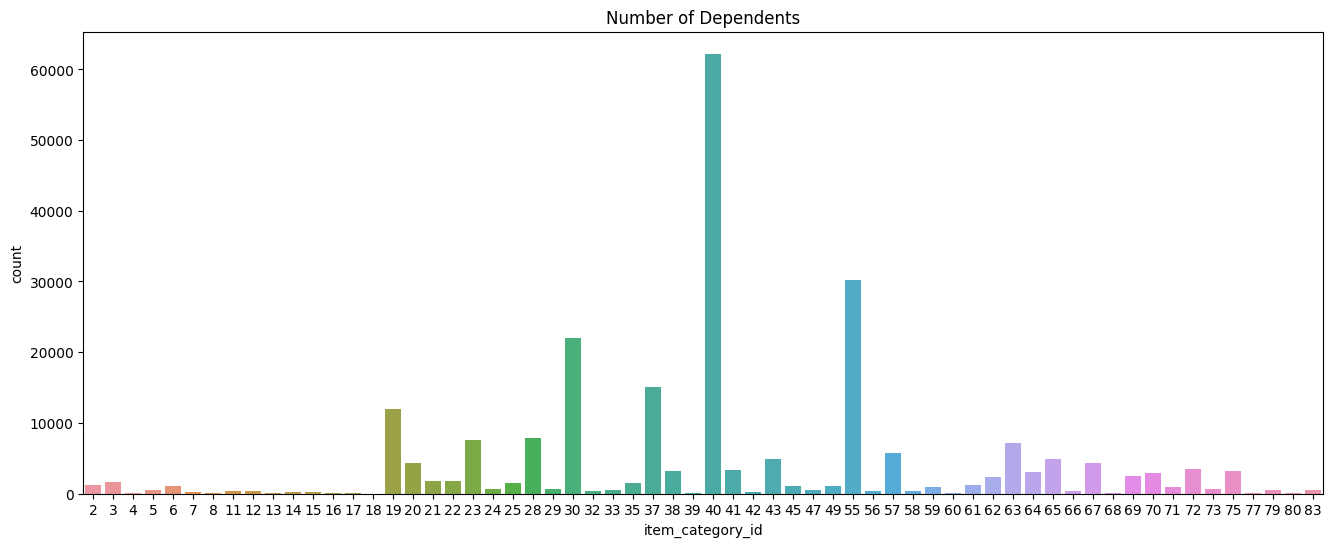

In [51]:
plt.figure(figsize=(16,6))
sns.countplot(x = 'item_category_id', data = sales).set_title('Number of Dependents')

<Axes: xlabel='date'>

<Figure size 1600x600 with 0 Axes>

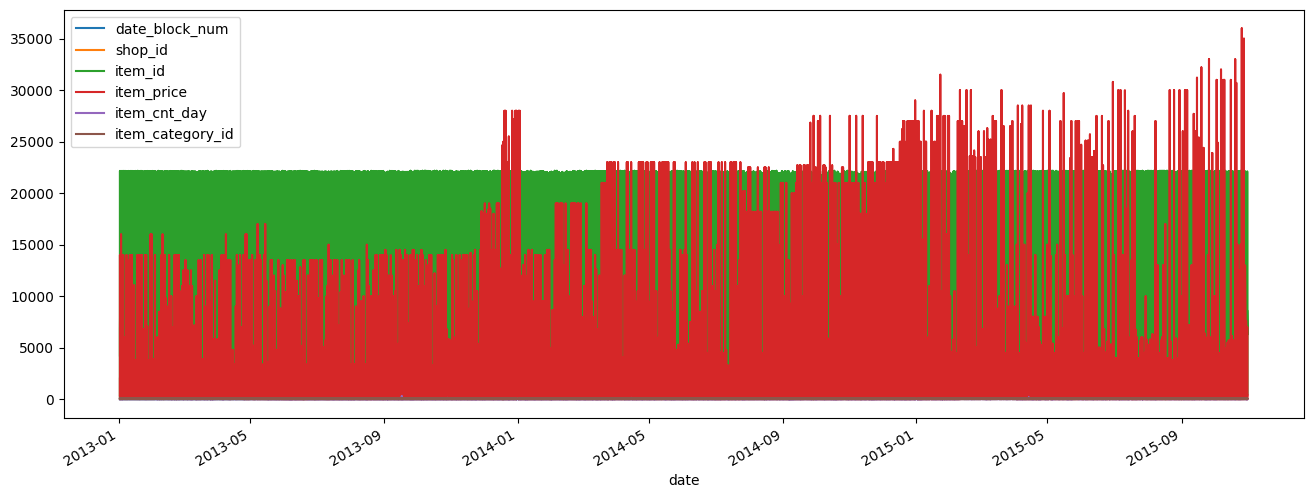

In [52]:
plt.figure(figsize=(16,6))
sales.iloc[:, 0:7].plot(figsize=(16,6))

In [53]:
dsa=sales.groupby(["date"])['sales_amount'].sum().reset_index()

In [54]:
dsa = dsa.set_index('date')

In [55]:
dsa.head()

,sales_amount
date,
2013-01-02,396376.10
2013-01-03,276933.11
2013-01-04,286408.00
2013-01-05,273245.00
2013-01-06,260775.00


In [56]:
df_sa = dsa['sales_amount'].resample('MS').mean()

<Axes: xlabel='date'>

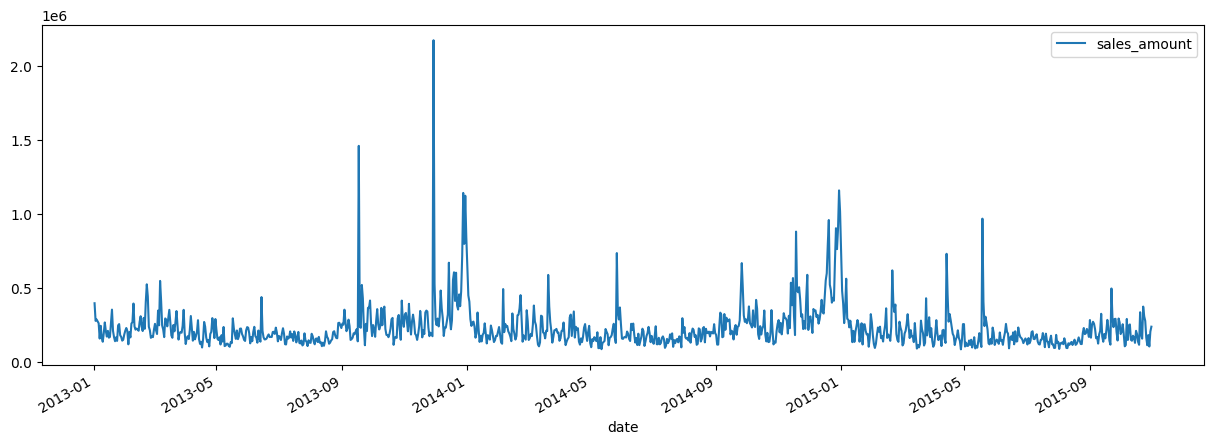

In [57]:
dsa.plot(figsize=(15,5))

<Axes: xlabel='date'>

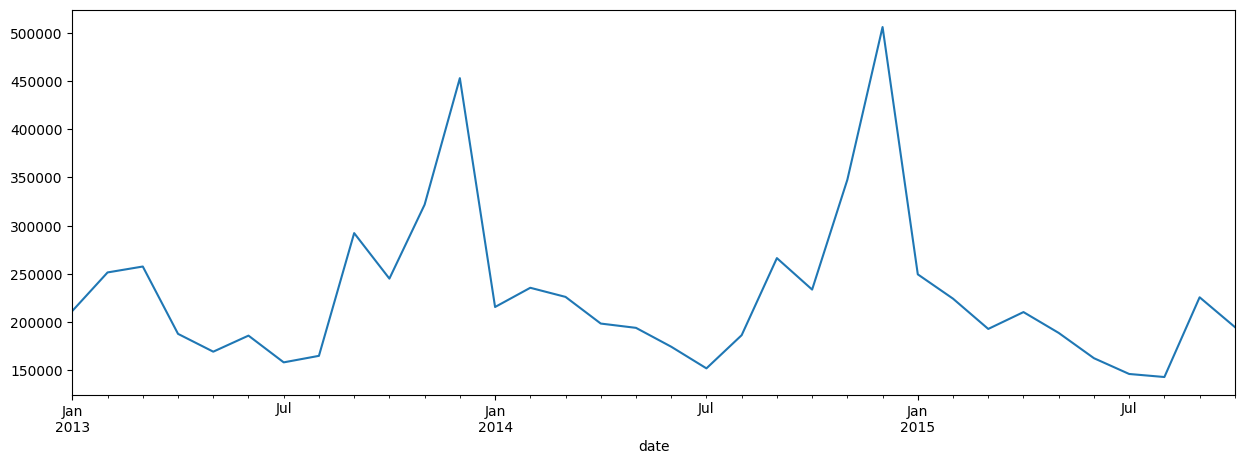

In [58]:
df_sa.plot(figsize=(15,5))

Text(0.5, 1.0, 'Box Plot on Sales amount')

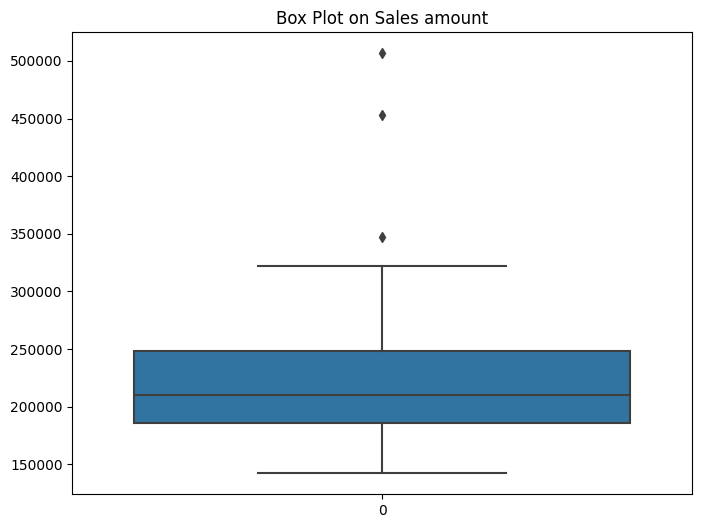

In [59]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(df_sa).set_title('Box Plot on Sales amount')

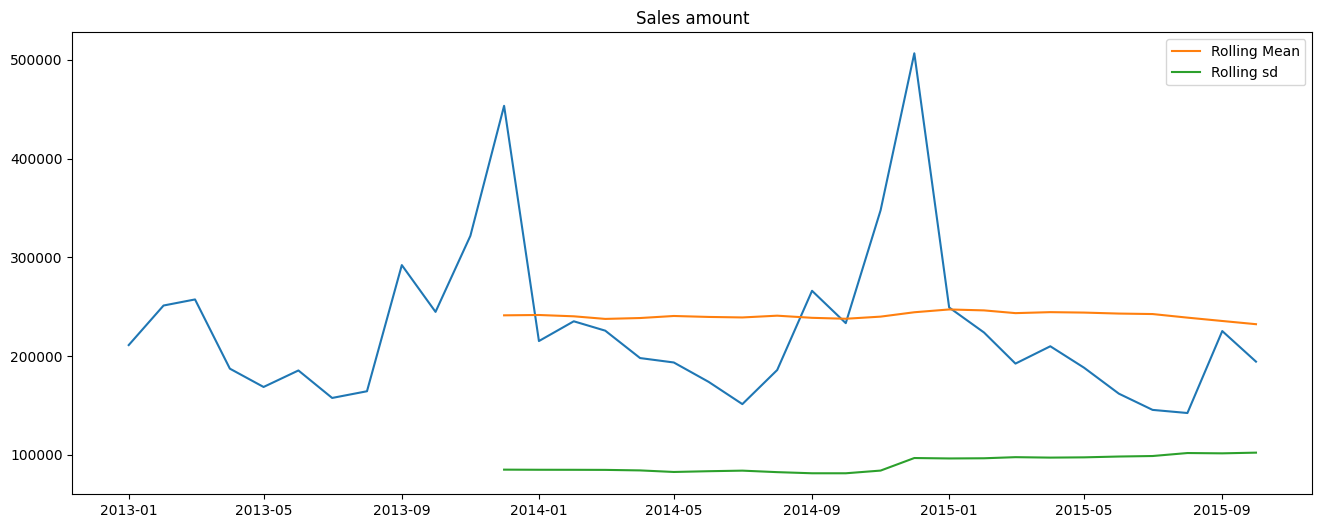

In [60]:
plt.figure(figsize=(16,6))
plt.title('Sales amount')
plt.plot(df_sa)
plt.plot(df_sa.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(df_sa.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

#### Cummulative Moving Average

In [61]:
cum_avg=df_sa.expanding().mean()

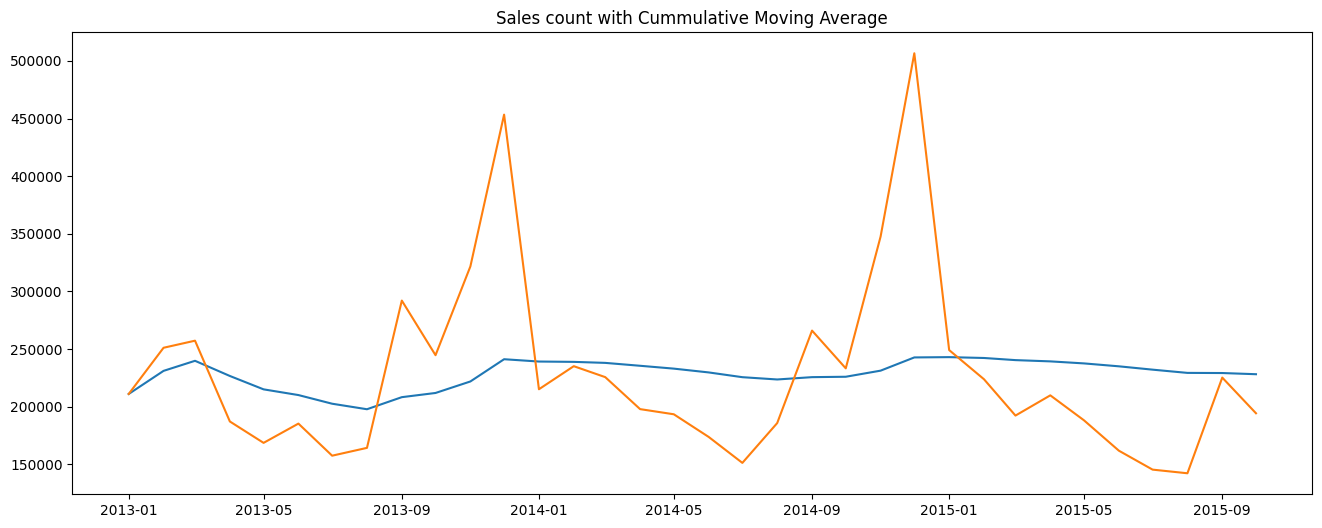

In [62]:
plt.figure(figsize=(16,6))
plt.title('Sales count with Cummulative Moving Average')
plt.plot(cum_avg)
plt.plot(df_sa)

#### Exponential Moving Average

In [63]:
ewa_o1 = df_sa.ewm(alpha=0.1,adjust=False).mean()
ewa_o2 = df_sa.ewm(alpha=0.2,adjust=False).mean()
ewa_o5 = df_sa.ewm(alpha=0.5,adjust=False).mean()
ewa_o7 = df_sa.ewm(alpha=0.01,adjust=False).mean()

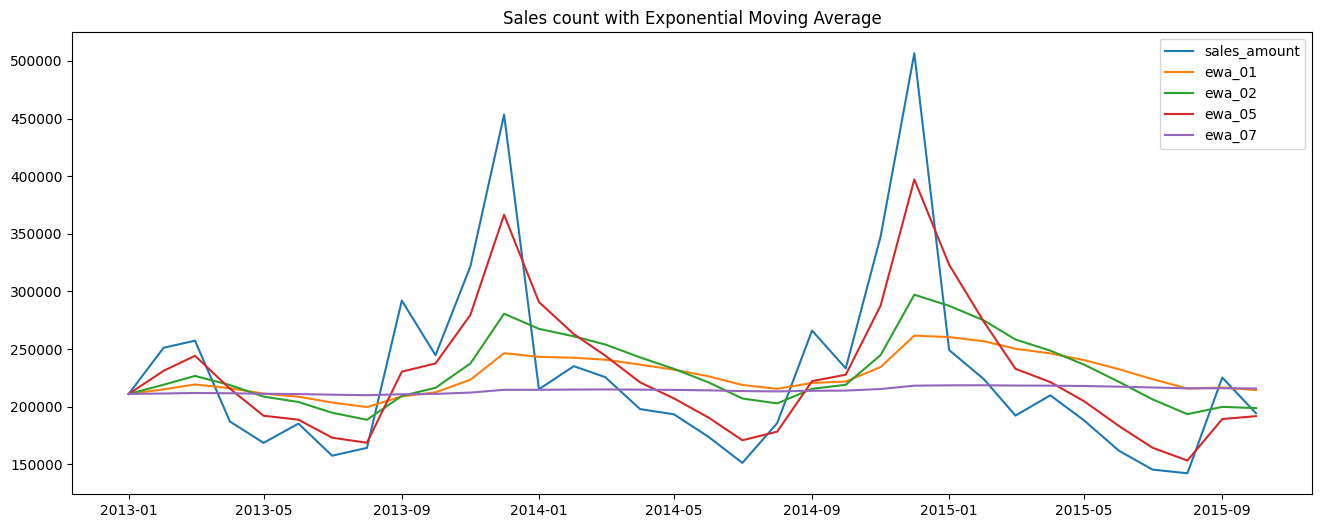

In [64]:
plt.figure(figsize=(16,6))
plt.title('Sales count with Exponential Moving Average')
plt.plot(df_sa,label='sales_amount')
plt.plot(ewa_o1,label='ewa_01');
plt.plot(ewa_o2,label='ewa_02');
plt.plot(ewa_o5,label='ewa_05');
plt.plot(ewa_o7,label='ewa_07');
plt.legend()

#### 5 Stationarity

Stationarity defines the stability of a series over time, indicating that its characteristics remain constant irrespective of when the observations occur. In simpler terms, it implies that the relationship between two points within a time series depends solely on their temporal distance and not on the direction (whether forward or backward).

Achieving stationarity in a time series simplifies the modeling process. Many statistical modeling techniques necessitate or assume the time series to exhibit stationarity.

Various tests, such as the Augmented Dickey-Fuller Test (ADF), KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test, and Phillips-Perron (PP) test, exist to assess stationarity. Among these, the ADF test stands as the most commonly employed method.

Upon performing transformations, if the p-value obtained from the DF test falls well within the 5% significance level, we infer the series' stationarity. To revert to the original series, an inverse transform function is readily available.

Now, equipped with the confirmation of stationarity, let's delve into generating forecasts!

Fuller test is a type of statistical test called a unit root test. It tests the null hypothesis that alpha=1 in the following model equation. alpha is the coefficient of the first lag on Y.

1. Null Hypothesis (Ho): Suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
2. Alternate Hypothesis (Ha): Suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
- P_value > 0.05 : Failure to reject the Null Hypothesis.
- p_value < 0.05 : Reject the Null Hypothesis and Accept the Alternate Hypothesis.

In [66]:
!pip install statsmodels

     ---------------------------------------- 9.2/9.2 MB 694.9 kB/s eta 0:00:00
     ------------------------------------ 233.9/233.9 kB 164.6 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
from statsmodels.tsa.stattools import adfuller

In [68]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [69]:
#sales amount
adf_test(df_sa)

ADF Statistics: -8.63044263956277
p- value: 5.774994011252432e-14
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [70]:
df = pd.DataFrame(df_sa)

In [72]:
df.head()

,sales_amount
date,
2013-01-01,211140.623667
2013-02-01,251200.607143
2013-03-01,257349.652258
2013-04-01,187279.800000
2013-05-01,168734.645161


In [73]:
## Use Techniques Differencing
df['First Difference']=df['sales_amount']-df['sales_amount'].shift(1)

In [74]:
adf_test(df['First Difference'].dropna())

ADF Statistics: -20.26768718723209
p- value: 0.0
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


[]

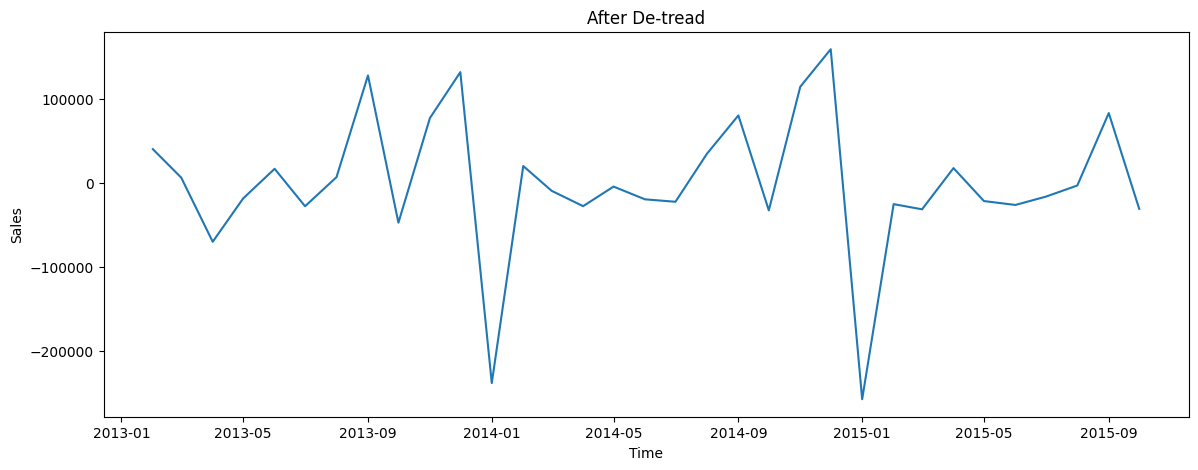

In [75]:
plt.figure(figsize=(14,5))
plt.title('After De-tread')
plt.xlabel('Time')
plt.ylabel('Sales')      # assuming the seasonality is 12 months long
plt.plot(df['First Difference'])
plt.plot()

In [76]:
df['12 Difference']=df['sales_amount']-df['sales_amount'].shift(12)

In [77]:
adf_test(df['12 Difference'].dropna())

ADF Statistics: -8.620184771421112
p- value: 6.135006541777741e-14
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


[]

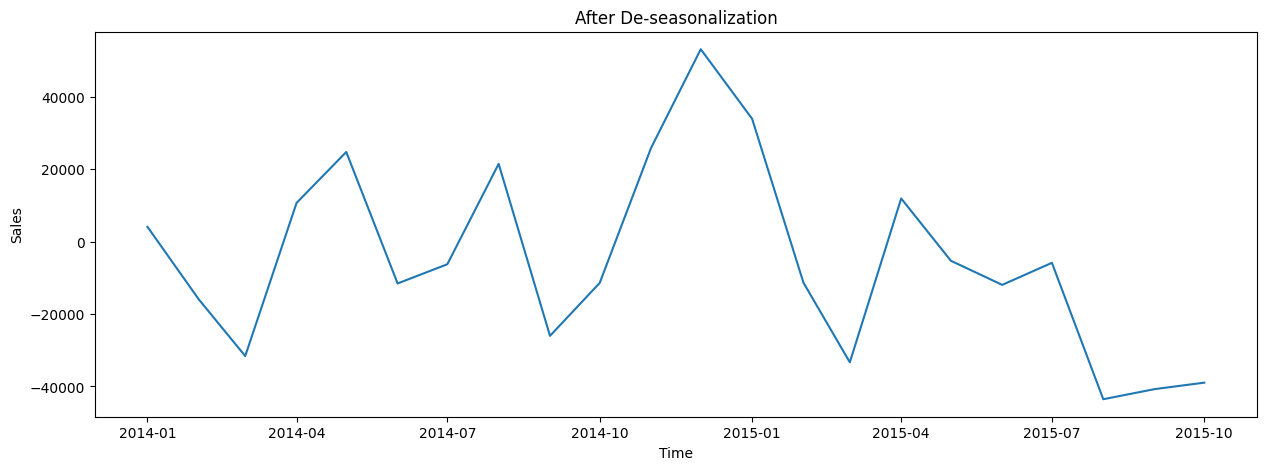

In [78]:
plt.figure(figsize=(15,5))
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')     # assuming the seasonality is 12 months long
plt.plot(df[['12 Difference']])
plt.plot()

In [79]:
df['Second Difference']=df['First Difference']-df['First Difference'].shift(1)

In [80]:
adf_test(df['Second Difference'].dropna())

ADF Statistics: -11.810398072473816
p- value: 8.888980613979835e-22
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


[]

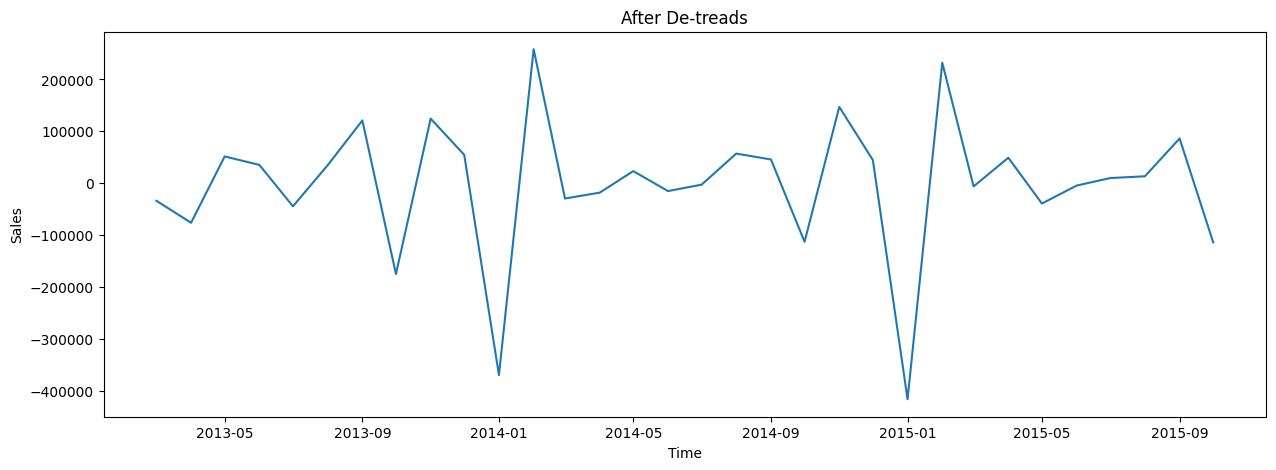

In [81]:
plt.figure(figsize=(15,5))
plt.title('After De-treads')
plt.xlabel('Time')
plt.ylabel('Sales')     # assuming the seasonality is 12 months long
plt.plot(df[['Second Difference']])
plt.plot()

[]

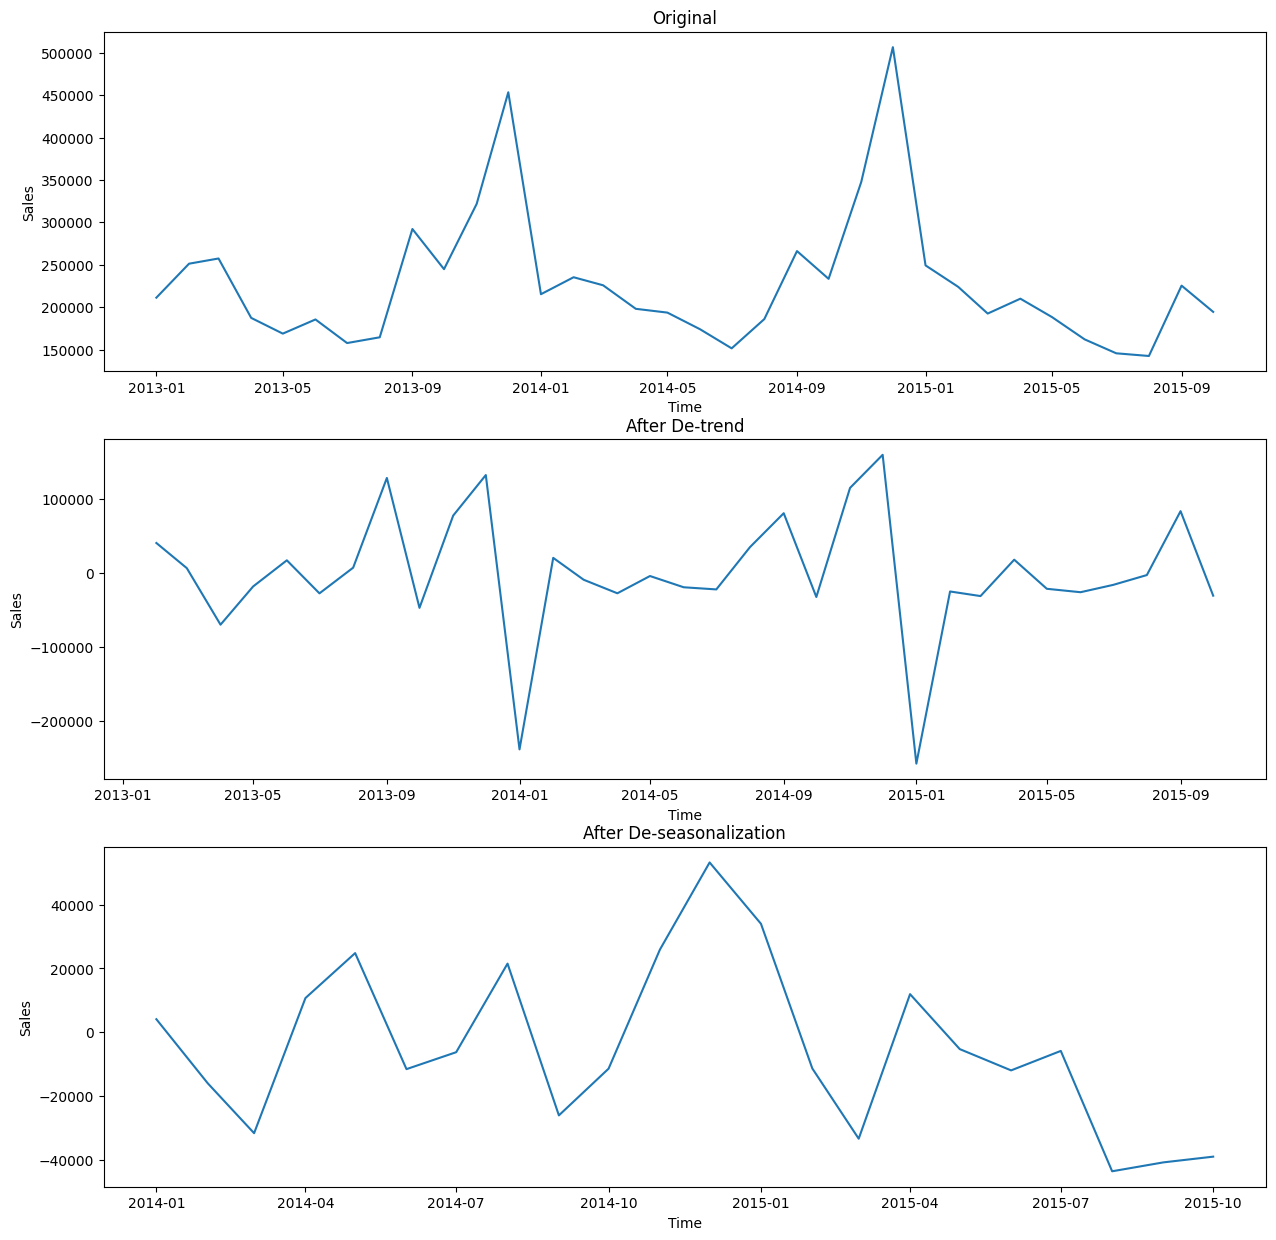

In [83]:
df_sa.astype('float')
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df_sa)

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df['First Difference'])
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df[['12 Difference']])       # assuming the seasonality is 12 months long
plt.plot()

#### Univariate Modelling

#### Plotting Auto-Correlation Chart (ACF) and Partial Correlation Chart(PACF)

In [84]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

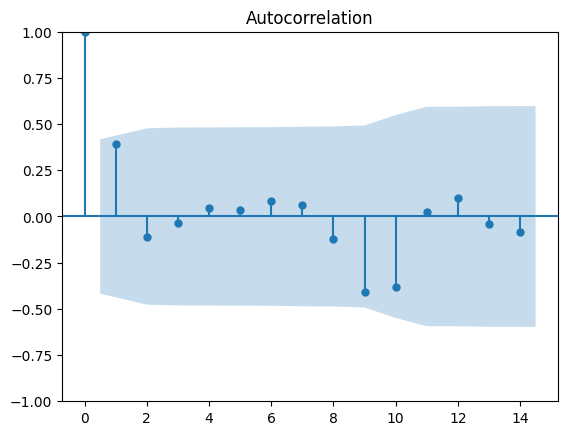

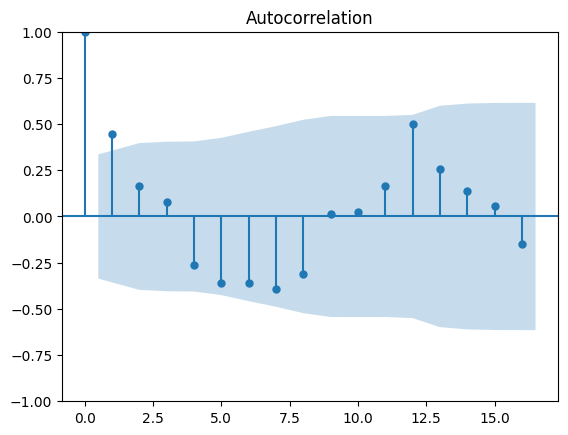

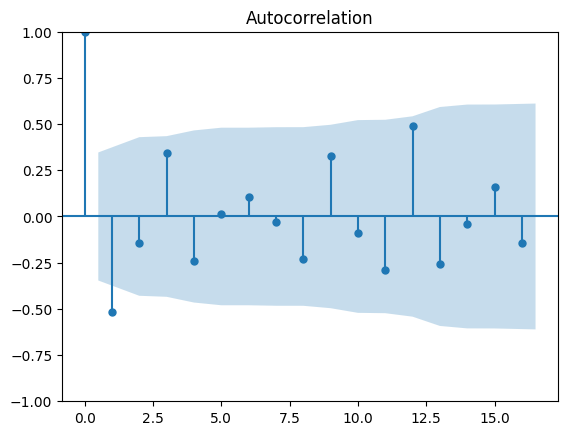

In [85]:
acf = plot_acf(df['12 Difference'].dropna())
acf = plot_acf(df["sales_amount"].dropna())
acf = plot_acf(df["Second Difference"].dropna())

From the ACF Chart, it is clear that the strongest lags occur at 0 and 1.

Similarly, from the PACF, the strongest lag occur at 1 and 2.

Let's create simple ARIMA model using combination of these above values and see which performs best.

#### Creating ARIMA MODEL

ARIMA stands for Autoregressive Integrated Moving Average. It is a widely used and powerful statistical method for time series forecasting and analysis.

ARIMA model is a combination of three components:

1. AutoRegressive (AR) part: This component models the relationship between an observation and a number of lagged observations (also known as autoregressive terms). It uses the dependency between an observation and its previous observations at fixed intervals.

2. Integrated (I) part: This component accounts for differencing the time series to make it stationary. Stationarity is essential in time series analysis, and the integrated part represents the number of differences needed to achieve stationarity.

3. Moving Average (MA) part: This component models the relationship between an observation and a residual error from a moving average model applied to lagged observations.

The ARIMA model is represented by the notation ARIMA(p, d, q), where:

- p: The order of the autoregressive (AR) part, indicating how many lagged observations are used in the model.
- d: The degree of differencing required to make the time series stationary.
- q: The order of the moving average (MA) part, indicating the size of the moving average window.
The ARIMA model is versatile and can handle a wide range of time series data, allowing analysts to capture different patterns and trends present in the data. It's widely used in various fields such as finance, economics, weather forecasting, and many others for making predictions and understanding the underlying patterns in time-dependent data.

It's important to note that while ARIMA is a powerful tool, its effectiveness depends on the appropriate selection of parameters (p, d, q) and the underlying characteristics of the time series being analyzed. Often, a process known as model identification and tuning is required to determine the optimal values for these parameters.

In [86]:
len(df_sa)

34

In [87]:
train_amount = df_sa.iloc[:25]
test_amount = df_sa.iloc[25:]

In [88]:
!pip install pmdarima

     ------------------------------------ 614.7/614.7 kB 204.7 kB/s eta 0:00:00
     ---------------------------------------- 2.8/2.8 MB 3.0 MB/s eta 0:00:00
     ------------------------------------ 104.6/104.6 kB 865.5 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [89]:
from pmdarima import auto_arima
## create a ARIMA model
from statsmodels.tsa.arima_model import ARIMA

In [90]:
model_amount = auto_arima(df_sa,m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=14.12 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=512.763, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=514.688, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=515.819, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=511.809, Time=0.04 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=512.549, Time=0.08 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=512.491, Time=0.12 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=514.332, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=515.117, Time=0.13 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=516.955, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 16.200 seconds


In [91]:
model_amount.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   34
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -254.905
Date:                  Wed, 06 Dec 2023   AIC                            511.809
Time:                          12:16:58   BIC                            512.900
Sample:                      01-01-2013   HQIC                           512.066
                           - 10-01-2015                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.797e+08   1.93e+08      3.010      0.003    2.02e+08    9.57e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.82   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.05   Prob(JB):                         0.66
Heteroskedasticity (H):               2.50   Skew:                             0.39
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
model_amount

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [93]:
import statsmodels.api as sm

In [94]:
model = sm.tsa.arima.ARIMA(train_amount, order=(1,2,5))
model_Arima_fit = model.fit()

C:\Python3.11.0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [95]:
model_Arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           sales_amount   No. Observations:                   25
Model:                 ARIMA(1, 2, 5)   Log Likelihood                -298.697
Date:                Wed, 06 Dec 2023   AIC                            611.395
Time:                        12:18:26   BIC                            619.343
Sample:                    01-01-2013   HQIC                           613.394
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2913      2.816      0.103      0.918      -5.228       5.811
ma.L1         -1.4061      2.551     -0.551      0.581      -6.405       3.593
ma.L2          0.3130      2.800      0.112      0.911      -5.174       5.800
ma.L3          0.4960      1.107      0.448      0.654      -1.674       2.666
ma.L4         -0.6945      1.810     -0.384      0.701      -4.242       2.853
ma.L5          0.3612      1.126      0.321      0.748      -1.846       2.568
sigma2      1.734e+10   3.41e-10   5.09e+19      0.000    1.73e+10    1.73e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.78   Prob(JB):                         0.85
Heteroskedasticity (H):               1.69   Skew:                            -0.26
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.23e+36. Standard errors may be unstable.
"""

In [96]:
start = len(train_amount)
end = len(train_amount) + len(test_amount) - 1

In [97]:
pred=model_Arima_fit.predict(start,end)
residuals=test_amount-pred

In [98]:
pred

2015-02-01    279634.067643
2015-03-01    339686.973661
2015-04-01    235344.067045
2015-05-01    279898.293487
2015-06-01    295076.292462
2015-07-01    301698.374056
2015-08-01    305828.518171
2015-09-01    309232.877765
2015-10-01    312425.850365
Freq: MS, Name: predicted_mean, dtype: float64

<Axes: ylabel='Density'>

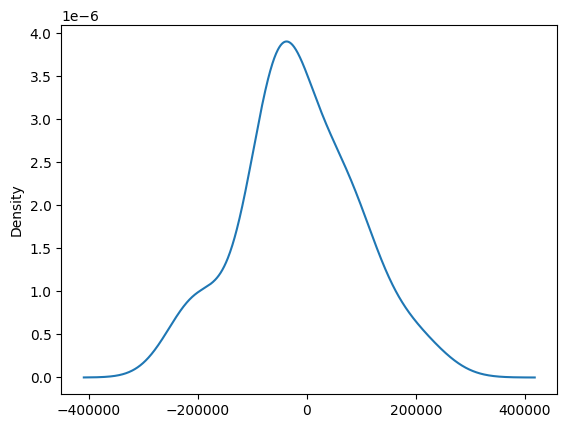

In [99]:
model_Arima_fit.resid.plot(kind='kde')

Text(0.5, 1.0, ' Sales in amount')

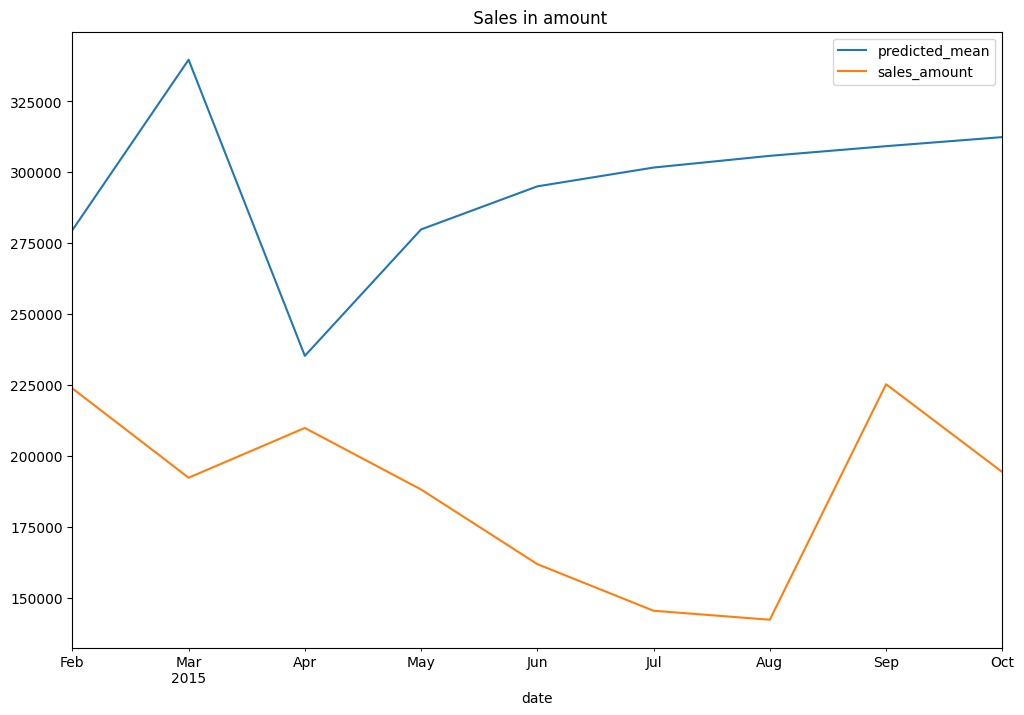

In [100]:
pred.plot(legend=True)
test_amount.plot(figsize=(12,8),legend=True)
plt.title(" Sales in amount")

In [101]:
model_amount

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

#### Creating an SARIMA Model

The Seasonal AutoRegressive Integrated Moving Average (SARIMA) model is an extension of the ARIMA (AutoRegressive Integrated Moving Average) model that incorporates seasonality into time series forecasting. SARIMA models are particularly useful for analyzing and forecasting time series data that exhibit seasonal patterns or trends.

The SARIMA model is defined by several components:

1. Seasonal Component (S): SARIMA accounts for seasonality in the data. This component involves repeating patterns or cycles occurring over fixed intervals (e.g., daily, weekly, monthly). The seasonal component is denoted by (S) and is usually represented by the number of seasonal periods (e.g., 12 for monthly data if the season is yearly).

2. Non-Seasonal Components (p, d, q): Similar to ARIMA models, SARIMA includes non-seasonal components:

- (p) represents the autoregressive (AR) order, which captures the relationship between an observation and a certain number of lagged observations.
- (d) denotes the differencing order needed to make the series stationary.
- (q) indicates the moving average (MA) order, which captures the dependency between an observation and a residual error from a moving average model applied to lagged observations.
3. Seasonal Non-Seasonal Components (P, D, Q): SARIMA also includes seasonal non-seasonal components similar to (p), (d), and (q), but applied to the seasonal part of the series:

- (P) denotes the seasonal autoregressive order.
- (D) represents the seasonal differencing order.
- (Q) indicates the seasonal moving average order.

The notation for a SARIMA model is typically expressed as SARIMA((p, d, q))((P, D, Q))(_S), where:

- (p, d, q) are the non-seasonal orders.
- (P, D, Q) are the seasonal orders.
- (S) represents the length of the seasonal cycle (e.g., monthly seasonality might use (S=12) for yearly cycles).

SARIMA models are versatile and capable of capturing both the trend and seasonality in time series data. They are widely used in various fields, including economics, finance, and climate forecasting, to analyze and forecast data with both seasonal and non-seasonal patterns. These models help account for and predict the complex behavior of time series data with multiple components.

In [102]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_amount = SARIMAX(train_amount,order=(0, 0, 0),seasonal_order=(0, 1, 0, 12),enforce_invertibility=False)
result_amount = model_amount.fit()
result_amount.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:             sales_amount   No. Observations:                   25
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -150.281
Date:                  Wed, 06 Dec 2023   AIC                            302.563
Time:                          12:24:04   BIC                            303.128
Sample:                      01-01-2013   HQIC                           302.446
                           - 01-01-2015                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.877e+08   1.78e+08      2.740      0.006    1.39e+08    8.37e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.20   Prob(JB):                         0.74
Heteroskedasticity (H):               3.45   Skew:                             0.26
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

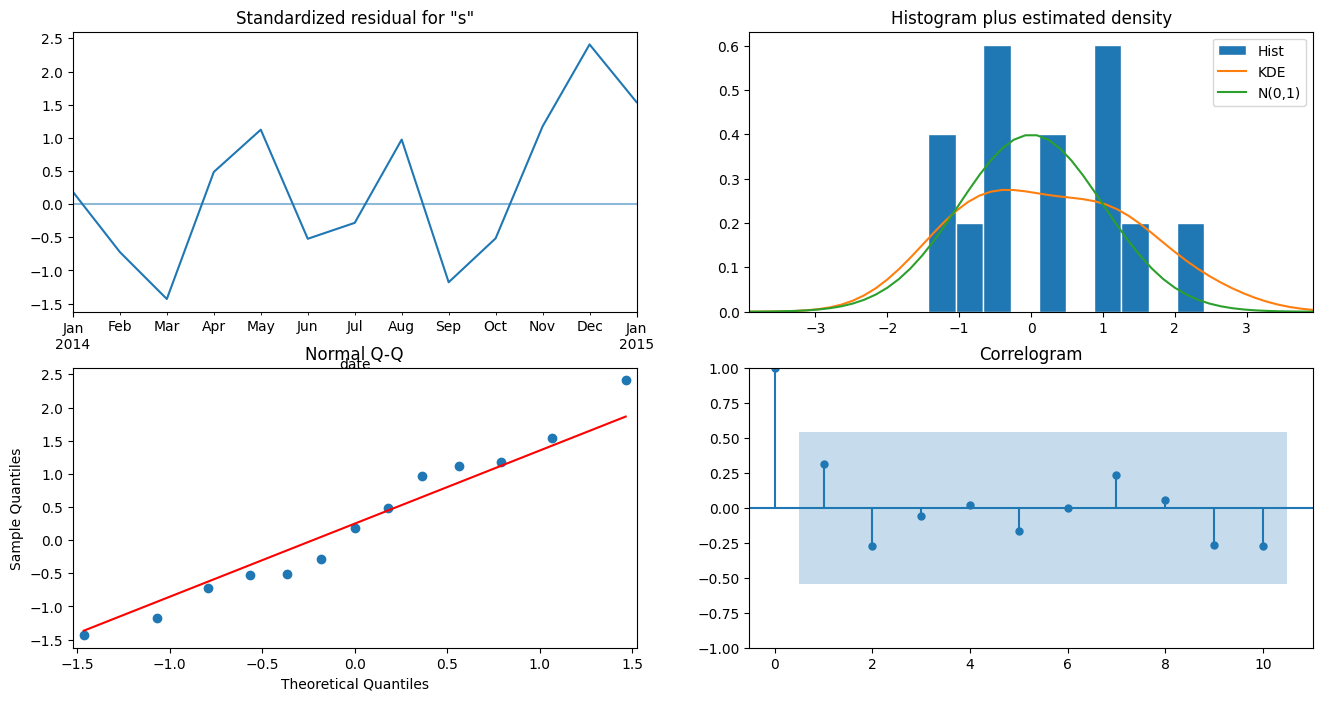

In [103]:
result_amount.plot_diagnostics(figsize=(16,8))
plt.show()

In [104]:
prediction_amount = result_amount.predict(start,end).rename('SARIMA model predictions')

<Axes: >

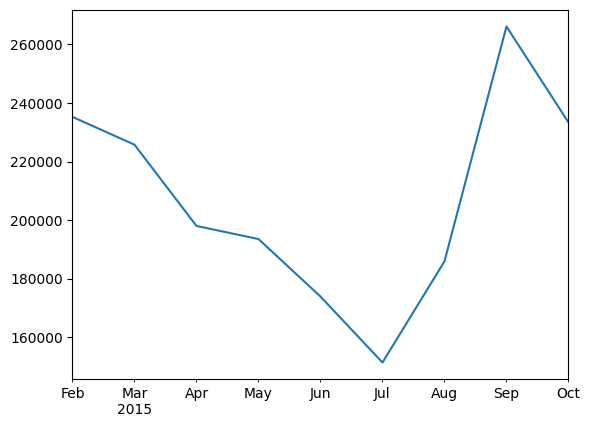

In [105]:
prediction_amount.plot()

Text(0.5, 1.0, ' Sales in amount')

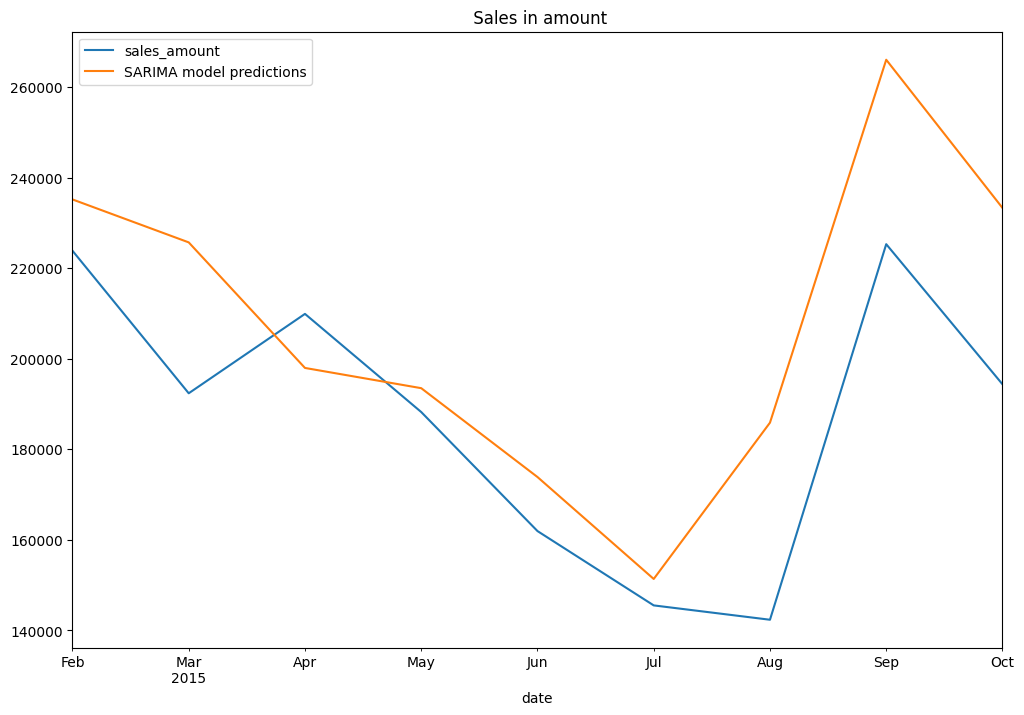

In [106]:
test_amount.plot(figsize=(12,8),legend=True)
prediction_amount.plot(legend=True)
plt.title(" Sales in amount")

Text(0.5, 1.0, ' Sales in amount')

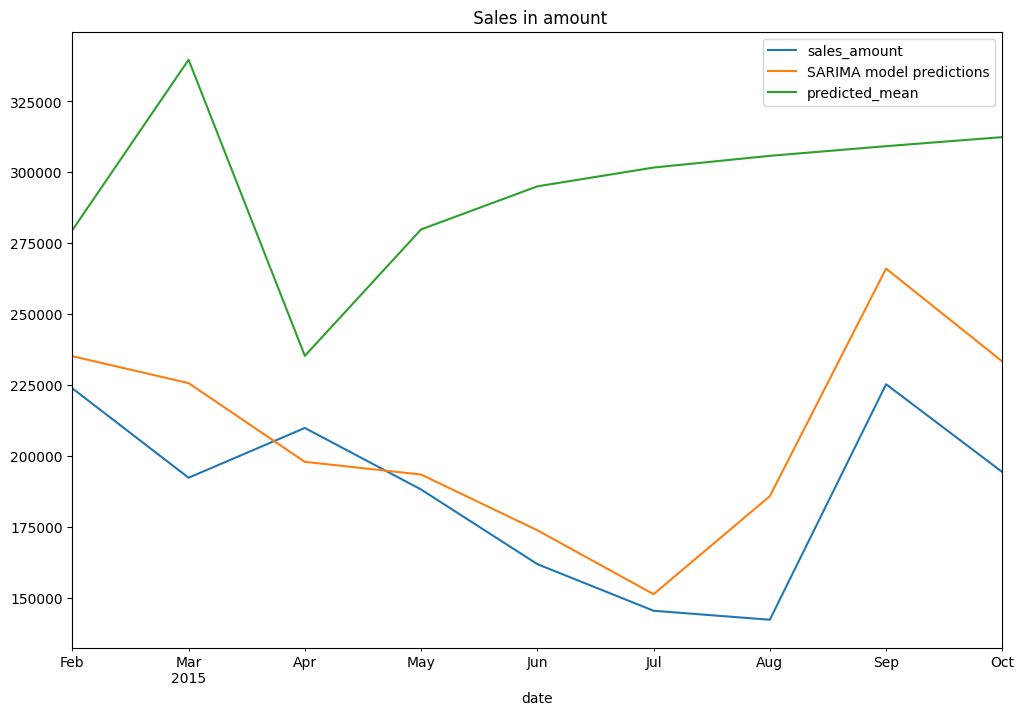

In [107]:
test_amount.plot(figsize=(12,8),legend=True)
prediction_amount.plot(legend=True)
pred.plot(legend=True)
plt.title(" Sales in amount")

In [108]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [109]:
mean_squared_error(test_amount,prediction_amount)

740205372.4692397

In [110]:
rmse(test_amount,prediction_amount)

27206.71557665937

In [111]:
test_amount.mean()

187119.89954983344

In [112]:
model_amount_final = SARIMAX(df_sa,order=(0, 0, 0),seasonal_order=(0, 1, 0, 12),enforce_invertibility=False)

In [113]:
result_amount_final = model_amount_final.fit()

In [114]:
forecast_amount = result_amount_final.predict(len(df_sa),len(df_sa)+11,typ='levels').rename('SARIMA forecast')

C:\Python3.11.0\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sales in amount')

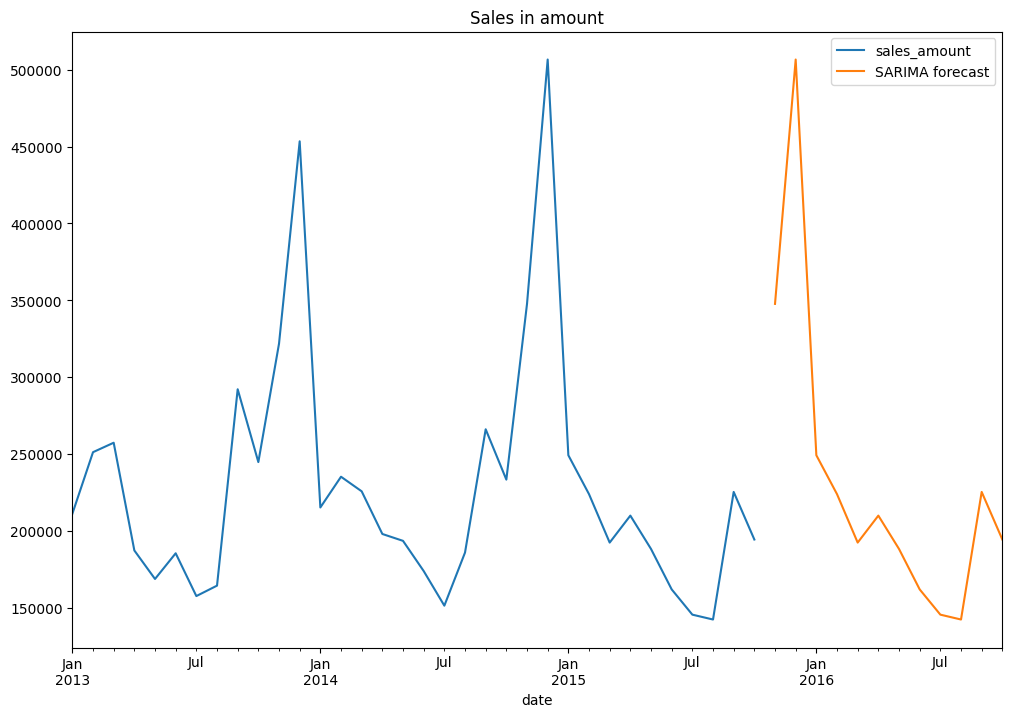

In [115]:
df_sa.plot(legend=True,figsize=(12,8))
forecast_amount.plot(legend=True)
plt.title("Sales in amount")

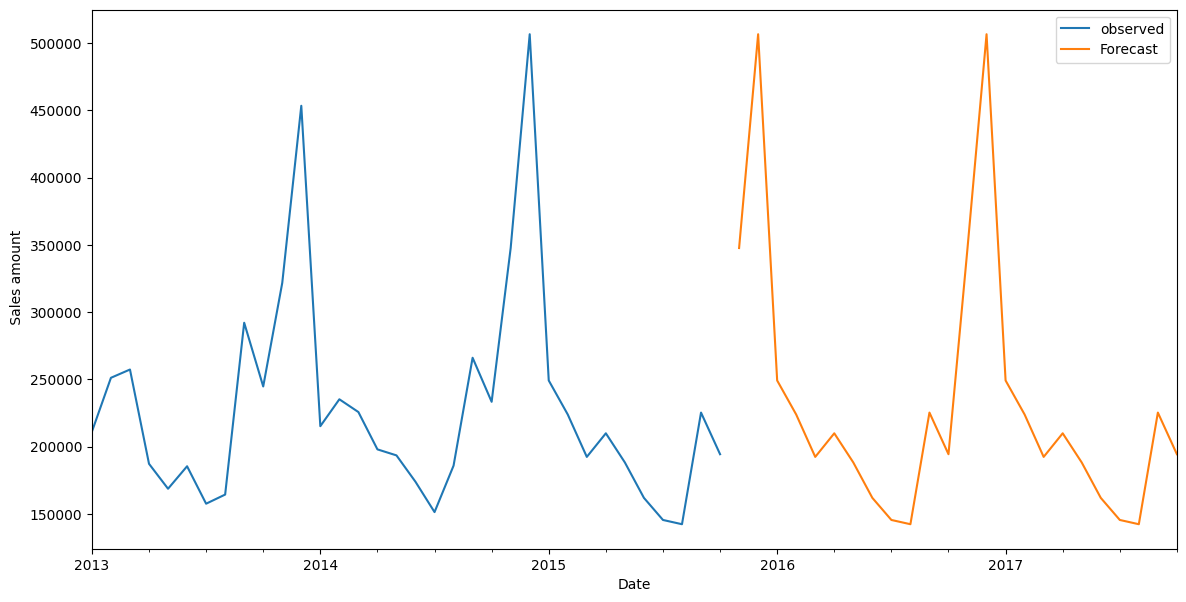

In [116]:
pred_amount = result_amount_final.get_forecast(steps=24)
pred_ci_amount = pred_amount.conf_int()
ax = df_sa.plot(label='observed',figsize=(14,7))
pred_amount.predicted_mean.plot(ax=ax,label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(' Sales amount')
plt.legend()
plt.show()

#### Time series modelling with prophet

In [117]:
!pip install prophet --quiet


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [118]:
from prophet import Prophet

In [119]:
df = df_sa.to_frame()
df.head()

,sales_amount
date,
2013-01-01,211140.623667
2013-02-01,251200.607143
2013-03-01,257349.652258
2013-04-01,187279.800000
2013-05-01,168734.645161


In [120]:
df['ds'] = df.index

In [121]:
df.columns = ['y','ds']

In [122]:
df.head()

,y,ds
date,,
2013-01-01,211140.623667,2013-01-01
2013-02-01,251200.607143,2013-02-01
2013-03-01,257349.652258,2013-03-01
2013-04-01,187279.800000,2013-04-01
2013-05-01,168734.645161,2013-05-01


In [123]:
model = Prophet()

In [124]:
model.fit(df)

12:49:36 - cmdstanpy - INFO - Chain [1] start processing
12:50:13 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
future = model.make_future_dataframe(periods=24,freq='MS')

In [126]:
future

,ds
0,2013-01-01
1,2013-02-01
2,2013-03-01
3,2013-04-01
4,2013-05-01
5,2013-06-01
6,2013-07-01
7,2013-08-01
8,2013-09-01
9,2013-10-01


In [127]:
forecast = model.predict(future)

In [128]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,242070.977329,206004.168207,217797.627072,242070.977329,242070.977329,-30294.291976,-30294.291976,-30294.291976,-30294.291976,-30294.291976,-30294.291976,0.0,0.0,0.0,211776.685353
1,2013-02-01,241405.313113,248052.546467,260585.333507,241405.313113,241405.313113,13023.024267,13023.024267,13023.024267,13023.024267,13023.024267,13023.024267,0.0,0.0,0.0,254428.337380
2,2013-03-01,240804.068098,252406.410618,265685.856151,240804.068098,240804.068098,18236.004785,18236.004785,18236.004785,18236.004785,18236.004785,18236.004785,0.0,0.0,0.0,259040.072883
3,2013-04-01,240138.403964,178852.427411,191684.158027,240138.403964,240138.403964,-54965.274372,-54965.274372,-54965.274372,-54965.274372,-54965.274372,-54965.274372,0.0,0.0,0.0,185173.129592
4,2013-05-01,239494.212892,162281.586888,175326.945891,239494.212892,239494.212892,-70406.782192,-70406.782192,-70406.782192,-70406.782192,-70406.782192,-70406.782192,0.0,0.0,0.0,169087.430699
5,2013-06-01,238828.548827,172485.681599,185019.344447,238828.548827,238828.548827,-59857.543727,-59857.543727,-59857.543727,-59857.543727,-59857.543727,-59857.543727,0.0,0.0,0.0,178971.005100
6,2013-07-01,238184.094636,143350.493057,156940.937410,238184.094636,238184.094636,-88072.666281,-88072.666281,-88072.666281,-88072.666281,-88072.666281,-88072.666281,0.0,0.0,0.0,150111.428355
7,2013-08-01,237518.158305,161363.366603,174123.106856,237518.158305,237518.158305,-69620.007629,-69620.007629,-69620.007629,-69620.007629,-69620.007629,-69620.007629,0.0,0.0,0.0,167898.150676
8,2013-09-01,236852.221917,281328.182645,294254.409801,236852.221917,236852.221917,50987.911203,50987.911203,50987.911203,50987.911203,50987.911203,50987.911203,0.0,0.0,0.0,287840.133121
9,2013-10-01,236207.767387,237468.779833,249669.382523,236207.767387,236207.767387,7288.174763,7288.174763,7288.174763,7288.174763,7288.174763,7288.174763,0.0,0.0,0.0,243495.942150


In [129]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

Text(57.097222222222214, 0.5, 'Sales')

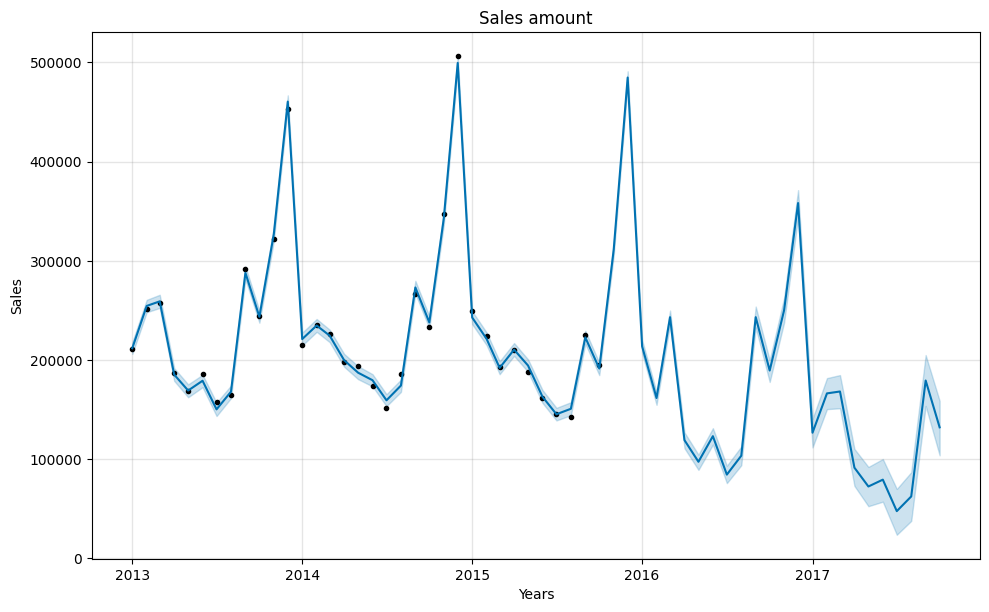

In [130]:
model.plot(forecast);
plt.title('Sales amount')
plt.xlabel('Years')
plt.ylabel('Sales')

In [141]:
!pip install plotly


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 15.6/15.6 MB 595.0 kB/s eta 0:00:00


In [148]:
from prophet.plot import plot_plotly, plot_components_plotly

<Axes: xlabel='ds'>

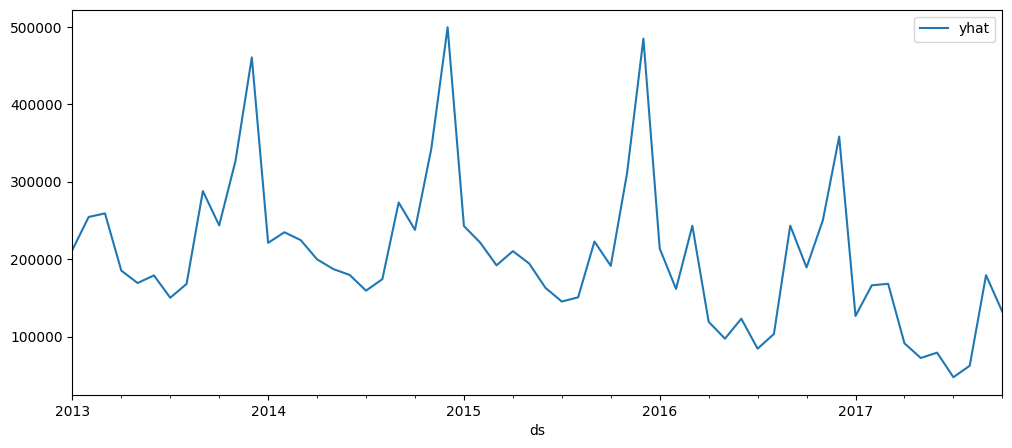

In [149]:
forecast.plot(x='ds',y='yhat',figsize=(12,5))

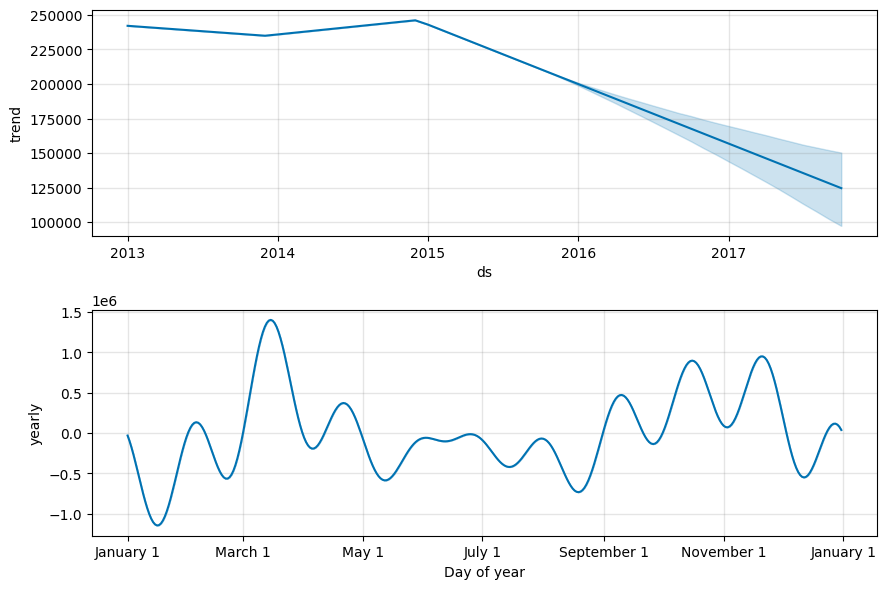

In [136]:
model.plot_components(forecast);

#### 9 Future Scope

Algorithms to Try Out:
1. SARIMA with Different Parameters:
- Experiment with SARIMA models using various combinations of seasonal (365 for yearly data) and non-seasonal orders (P, D, Q).

2. SARIMAX with Exogenous Regressors:
- Utilize SARIMAX models where additional features from the dataset (exogenous regressors) can be incorporated to potentially improve forecasting accuracy.

3. LSTM (Long Short-Term Memory):
- Explore deep learning techniques like LSTM, known for their effectiveness in handling time-series data.

4. NeuralProphet:
- Experiment with NeuralProphet, a framework that combines deep learning with Facebook Prophet for potentially enhanced performance in time series forecasting.

5. Specialized Time Series Frameworks:
- Consider using specialized time series frameworks like Darts, ThymeBoost, or LGBM (LightGBM) to benefit from their specific advantages in terms of efficiency, ease of use, and potentially improved performance.


Feature Engineering:

1. Additional Features:
- Utilize additional features derived from timestamp data, such as sine and cosine signals of time-related attributes (day, week, etc.) to enhance feature representation.

2. Data Preprocessing Techniques:
- Experiment with scaling data, removing or adding different features, and employing various preprocessing techniques to improve model performance.

Challenges to Address:

1. Memory Constraints:
- Address issues related to memory constraints on platforms like Google Colab by optimizing code, reducing memory usage, or considering alternative computing resources.

2. Hyperparameter Tuning:
- Investigate hyperparameter optimization techniques to explore more precise configurations for models while handling resource constraints efficiently.

3. Time and Resource Management:
- Consider parallel processing or distributing computations where feasible to manage resource-intensive tasks effectively.

In summary, the future scope involves exploring various algorithms, incorporating additional features, leveraging specialized frameworks, and addressing challenges such as memory constraints and hyperparameter tuning to enhance the accuracy and performance of time series forecasting models. Experimentation, optimization, and incorporating diverse approaches can lead to improved forecasting results and model robustness.